## First Approach

GPU is now being used!
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                 

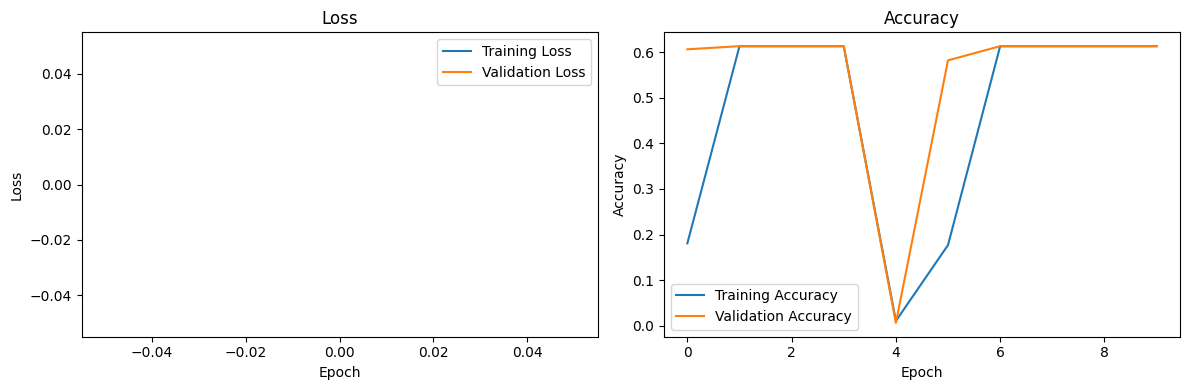

Evaluating model on validation set...
59/59 [==============================] - 4s 56ms/step
Validation Metrics:
Accuracy: 0.6067
Dice Score: 0.0126
IoU Score: 0.0063


In [1]:
#!/usr/bin/env python
# coding: utf-8

# Required Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Dropout, 
                                     UpSampling2D, concatenate)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# GPU Setup
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("GPU is now being used!")
    except RuntimeError as e:
        print(e)

# Enabling mixed precision training to improve training speed and reduce memory usage -- no effect on accuracy
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Paths
IMAGE_DIR = r".\MSFD\MSFD\1\face_crop"
MASK_DIR = r".\MSFD\MSFD\1\face_crop_segmentation"

# Image Constants
IMG_HEIGHT, IMG_WIDTH = 128, 128

def load_data(image_dir, mask_dir):
    """Loads images and masks, resizes, and normalizes them."""
    image_filenames = sorted(os.listdir(image_dir))
    mask_filenames = sorted(os.listdir(mask_dir))

    images, masks = [], []

    for img_name, mask_name in zip(image_filenames, mask_filenames):
        img_path, mask_path = os.path.join(image_dir, img_name), os.path.join(mask_dir, mask_name)

        # Load and preprocess image
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT)) / 255.0
        images.append(img)

        # Load and preprocess mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT)) / 255.0
        masks.append(mask)

    return np.array(images), np.array(masks).reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)

# Load dataset
X, y = load_data(IMAGE_DIR, MASK_DIR)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3)):
    """Builds a U-Net model for segmentation."""
    
    inputs = Input(input_size)

    def conv_block(x, filters):
        """Convolutional block with two Conv2D layers."""
        x = Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = Conv2D(filters, 3, activation='relu', padding='same')(x)
        return x

    def upconv_block(x, skip, filters):
        """UpSampling + Concatenation + Conv Block."""
        x = UpSampling2D(size=(2, 2))(x)
        x = concatenate([x, skip], axis=3)
        x = conv_block(x, filters)
        return x

    # Encoder
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bridge
    conv4 = conv_block(pool3, 512)
    drop4 = Dropout(0.5)(conv4)

    # Decoder
    conv5 = upconv_block(drop4, conv3, 256)
    conv6 = upconv_block(conv5, conv2, 128)
    conv7 = upconv_block(conv6, conv1, 64)

    # Output Layer
    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)

    return Model(inputs, outputs)

# Model Compilation
model = unet_model()
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

model.summary()

# Callbacks
checkpoint = ModelCheckpoint('unet_face_mask.keras', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Enable Mixed Precision Training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Training
print("Training model...")
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=8,
                    epochs=20,
                    callbacks=[checkpoint, early_stopping])

# Plot Training History
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Evaluation Metrics
def dice_coef(y_true, y_pred, smooth=1):
    """Compute Dice Score (F1-score for segmentation)"""
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    
    intersection = np.sum(np.logical_and(y_true_f, y_pred_f))
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    """Compute Intersection over Union (IoU)"""
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    
    intersection = np.sum(np.logical_and(y_true_f, y_pred_f))
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def calculate_metrics(y_true, y_pred, threshold=0.5):
    """Calculate Accuracy, Dice Score, and IoU"""
    y_pred_binary = (y_pred > threshold).astype(np.float32)  # Ensure binary mask

    accuracy = np.mean((y_true == y_pred_binary).astype(np.float32))
    dice = dice_coef(y_true, y_pred_binary)
    iou = iou_coef(y_true, y_pred_binary)
    
    return accuracy, dice, iou
# Evaluate Model
print("Evaluating model on validation set...")
validation_predictions = model.predict(X_test)
val_accuracy, val_dice, val_iou = calculate_metrics(y_test, validation_predictions)

# Print Validation Metrics
print(f"Validation Metrics:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Dice Score: {val_dice:.4f}")
print(f"IoU Score: {val_iou:.4f}")


## Second Approach

GPU is now being used!
Epoch 1/30
939/939 [==============================] - ETA: 0s - loss: 0.3267 - accuracy: 0.5690 - mean_io_u: 0.4973
Epoch 1: val_loss improved from inf to 0.28841, saving model to unet_face_mask.keras
939/939 [==============================] - 137s 119ms/step - loss: 0.3267 - accuracy: 0.5690 - mean_io_u: 0.4973 - val_loss: 0.2884 - val_accuracy: 0.5777 - val_mean_io_u: 0.4973 - lr: 1.0000e-04
Epoch 2/30
938/939 [============================>.] - ETA: 0s - loss: 0.2891 - accuracy: 0.5786 - mean_io_u: 0.4973
Epoch 2: val_loss improved from 0.28841 to 0.28768, saving model to unet_face_mask.keras
939/939 [==============================] - 110s 117ms/step - loss: 0.2890 - accuracy: 0.5787 - mean_io_u: 0.4973 - val_loss: 0.2877 - val_accuracy: 0.5773 - val_mean_io_u: 0.4973 - lr: 1.0000e-04
Epoch 3/30
938/939 [============================>.] - ETA: 0s - loss: 0.2847 - accuracy: 0.5797 - mean_io_u: 0.4973
Epoch 3: val_loss improved from 0.28768 to 0.28300, saving mode

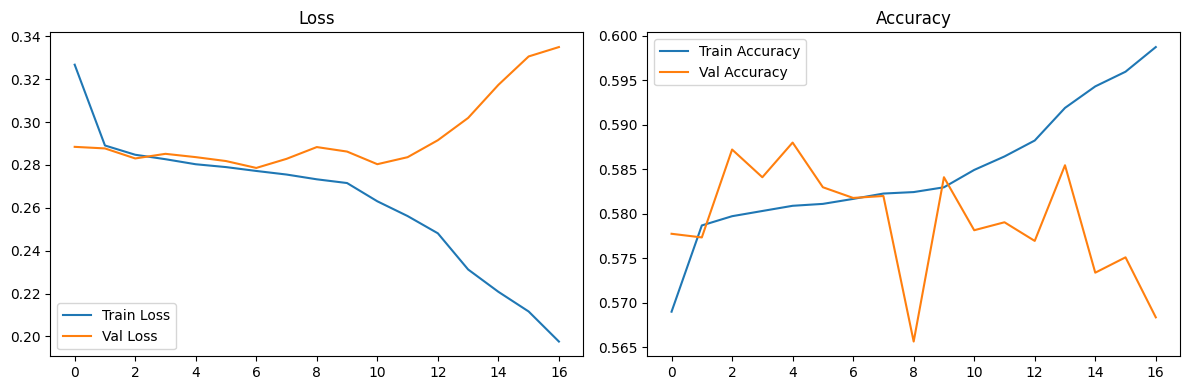

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Dropout, 
                                     UpSampling2D, concatenate, BatchNormalization, LeakyReLU)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm

# Enable GPU usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("GPU is now being used!")
    except RuntimeError as e:
        print(e)

# Define paths
IMAGE_DIR = r".\MSFD\MSFD\1\face_crop"
MASK_DIR = r".\MSFD\MSFD\1\face_crop_segmentation"

# Define image parameters
IMG_HEIGHT, IMG_WIDTH = 128, 128

# Function to load and preprocess images
def load_data(image_dir, mask_dir):
    image_filenames = sorted(os.listdir(image_dir))
    mask_filenames = sorted(os.listdir(mask_dir))
    images, masks = [], []
    
    for img_name, mask_name in zip(image_filenames, mask_filenames):
        img = cv2.imread(os.path.join(image_dir, img_name), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT)) / 255.0
        images.append(img)
        
        mask = cv2.imread(os.path.join(mask_dir, mask_name), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT)) / 255.0
        masks.append(mask)
    
    return np.array(images), np.array(masks).reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)

# Load dataset
X, y = load_data(IMAGE_DIR, MASK_DIR)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define U-Net model
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = Input(input_size)
    
    def conv_block(x, filters):
        x = Conv2D(filters, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2D(filters, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        return x
    
    def encoder_block(x, filters):
        c = conv_block(x, filters)
        p = MaxPooling2D(pool_size=(2, 2))(c)
        return c, p
    
    def decoder_block(x, skip, filters):
        x = UpSampling2D(size=(2, 2))(x)
        x = concatenate([x, skip], axis=3)
        x = conv_block(x, filters)
        return x
    
    c1, p1 = encoder_block(inputs, 64)
    c2, p2 = encoder_block(p1, 128)
    c3, p3 = encoder_block(p2, 256)
    
    bridge = conv_block(p3, 512)
    drop = Dropout(0.5)(bridge)
    
    d1 = decoder_block(drop, c3, 256)
    d2 = decoder_block(d1, c2, 128)
    d3 = decoder_block(d2, c1, 64)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(d3)
    
    return Model(inputs, outputs)

# Compile model
model = unet_model()
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

# Define callbacks
checkpoint = ModelCheckpoint('unet_face_mask.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=8,
                    epochs=30,
                    callbacks=[checkpoint, early_stopping, lr_scheduler])

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()


def dice_coef(y_true, y_pred, smooth=1):
    """Compute Dice Score (F1-score for segmentation)"""
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    
    intersection = np.sum(np.logical_and(y_true_f, y_pred_f))
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    """Compute Intersection over Union (IoU)"""
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    
    intersection = np.sum(np.logical_and(y_true_f, y_pred_f))
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def calculate_metrics(y_true, y_pred, threshold=0.5):
    """Calculate Accuracy, Dice Score, and IoU"""
    y_pred_binary = (y_pred > threshold).astype(np.float32)  # Ensure binary mask

    accuracy = np.mean((y_true == y_pred_binary).astype(np.float32))
    dice = dice_coef(y_true, y_pred_binary)
    iou = iou_coef(y_true, y_pred_binary)
    
    return accuracy, dice, iou





In [2]:
# Evaluate model
print("Evaluating model on validation set...")
validation_predictions = model.predict(X_test)
val_accuracy, val_dice, val_iou = calculate_metrics(y_test, validation_predictions)

print(f"Validation Metrics:\nAccuracy: {val_accuracy:.4f}\nDice Score: {val_dice:.4f}\nIoU Score: {val_iou:.4f}")

Evaluating model on validation set...
59/59 [==============================] - 9s 134ms/step
Validation Metrics:
Accuracy: 0.5818
Dice Score: 0.8799
IoU Score: 0.7856


## Third Approach

Epoch 1/30
939/939 [==============================] - 153s 134ms/step - loss: 0.3055 - accuracy: 0.5726 - mean_io_u: 0.4972 - val_loss: 0.3218 - val_accuracy: 0.6008 - val_mean_io_u: 0.4973
Epoch 2/30
939/939 [==============================] - 123s 131ms/step - loss: 0.2723 - accuracy: 0.5837 - mean_io_u: 0.4973 - val_loss: 0.3027 - val_accuracy: 0.6019 - val_mean_io_u: 0.4973
Epoch 3/30
939/939 [==============================] - 122s 130ms/step - loss: 0.2693 - accuracy: 0.5845 - mean_io_u: 0.4973 - val_loss: 0.2899 - val_accuracy: 0.5972 - val_mean_io_u: 0.4973
Epoch 4/30
939/939 [==============================] - 123s 131ms/step - loss: 0.2685 - accuracy: 0.5845 - mean_io_u: 0.4973 - val_loss: 0.2734 - val_accuracy: 0.5910 - val_mean_io_u: 0.4973
Epoch 5/30
939/939 [==============================] - 123s 131ms/step - loss: 0.2671 - accuracy: 0.5852 - mean_io_u: 0.4973 - val_loss: 0.2837 - val_accuracy: 0.5997 - val_mean_io_u: 0.4973
Epoch 6/30
939/939 [==============================

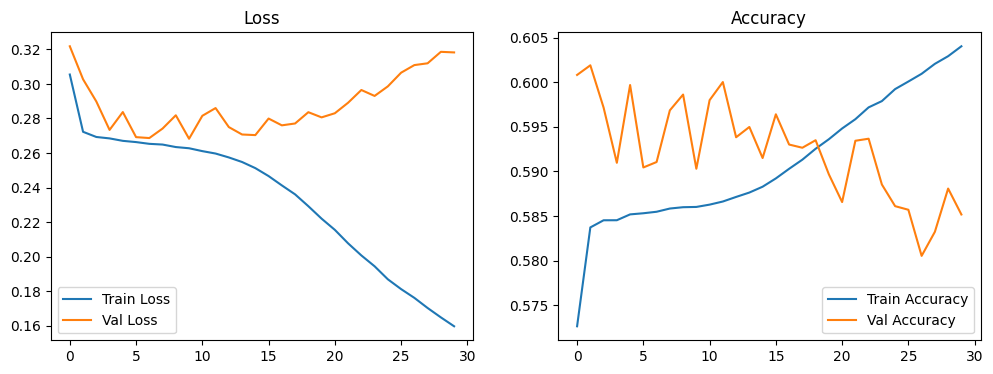

59/59 [==============================] - 12s 171ms/step
Validation Metrics:
Accuracy: 0.5852
Dice Score: 0.8686
IoU Score: 0.7677


In [2]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

def encoder_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    p = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    crop_size = (skip_features.shape[1] - x.shape[1]) // 2
    skip_features = tf.keras.layers.Cropping2D(crop_size)(skip_features)
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

def unet_model(input_shape=(128, 128, 3), num_classes=1):
    inputs = tf.keras.layers.Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu')(p4)
    b1 = tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu')(b1)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    outputs = tf.keras.layers.Conv2D(num_classes, 1, activation='sigmoid', padding='same')(d4)
    return tf.keras.models.Model(inputs, outputs, name="U-Net")

def load_data(image_dir, mask_dir, img_size=(128, 128)):
    image_filenames = sorted(os.listdir(image_dir))
    mask_filenames = sorted(os.listdir(mask_dir))
    images, masks = [], []
    for img_name, mask_name in zip(image_filenames, mask_filenames):
        img = cv2.imread(os.path.join(image_dir, img_name))
        img = cv2.resize(img, img_size) / 255.0
        images.append(img)
        mask = cv2.imread(os.path.join(mask_dir, mask_name), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size) / 255.0
        masks.append(mask)
    return np.array(images), np.array(masks).reshape(-1, *img_size, 1)

def dice_coef(y_true, y_pred, smooth=1):
    """Compute Dice Score (F1-score for segmentation)"""
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    
    intersection = np.sum(np.logical_and(y_true_f, y_pred_f))
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    """Compute Intersection over Union (IoU)"""
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    
    intersection = np.sum(np.logical_and(y_true_f, y_pred_f))
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def calculate_metrics(y_true, y_pred, threshold=0.5):
    """Calculate Accuracy, Dice Score, and IoU"""
    y_pred_binary = (y_pred > threshold).astype(np.float32)  # Ensure binary mask

    accuracy = np.mean((y_true == y_pred_binary).astype(np.float32))
    dice = dice_coef(y_true, y_pred_binary)
    iou = iou_coef(y_true, y_pred_binary)
    
    return accuracy, dice, iou

IMAGE_DIR = r".\MSFD\MSFD\1\face_crop"
MASK_DIR = r".\MSFD\MSFD\1\face_crop_segmentation"
X, y = load_data(IMAGE_DIR, MASK_DIR)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = unet_model()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=8)
model.save("unet_face_mask.h5")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.savefig('training_history.png')
plt.show()

validation_predictions = model.predict(X_test)
val_accuracy, val_dice, val_iou = calculate_metrics(y_test, validation_predictions)
print(f"Validation Metrics:\nAccuracy: {val_accuracy:.4f}\nDice Score: {val_dice:.4f}\nIoU Score: {val_iou:.4f}")


## Fourth Approach

Physical devices cannot be modified after being initialized
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 128, 128, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_28 (BatchN  (None, 128, 128, 64  256        ['conv2d_30[0][0]']              
 ormalization)                  

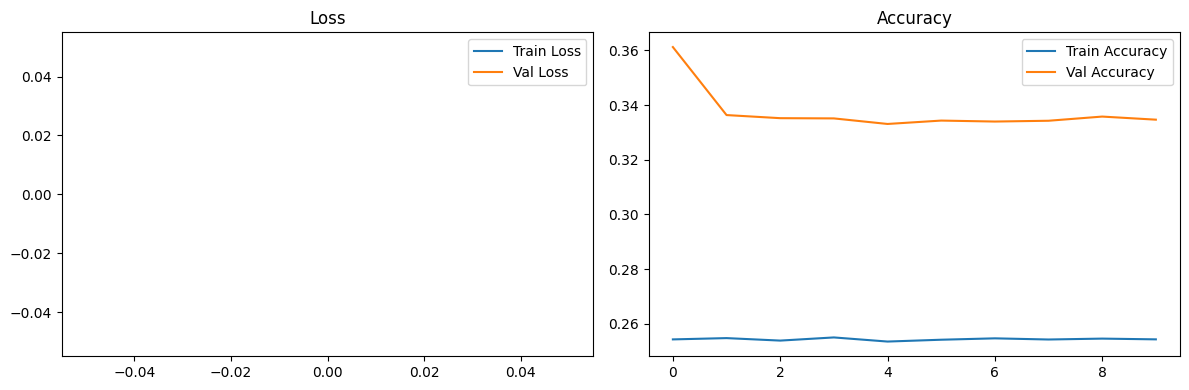

59/59 [==============================] - 4s 63ms/step
Validation Metrics:
Accuracy: 0.3612
Dice Score: 0.4360
IoU Score: 0.2787


In [4]:
# Required Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Dropout, 
                                     UpSampling2D, concatenate)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# GPU Setup
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("GPU is now being used!")
    except RuntimeError as e:
        print(e)

# Enabling mixed precision training to improve training speed and reduce memory usage -- no effect on accuracy
tf.keras.mixed_precision.set_global_policy('mixed_float16')
def encoder_block(inputs, num_filters):
    """Encoder block with convolution, activation, and max pooling."""
    x = Conv2D(num_filters, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    p = MaxPooling2D(pool_size=(2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    """Decoder block with transposed convolution and concatenation."""
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    crop_size = (skip_features.shape[1] - x.shape[1]) // 2
    skip_features = tf.keras.layers.Cropping2D(crop_size)(skip_features)
    x = concatenate([x, skip_features])
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

# Image Constants
IMG_HEIGHT, IMG_WIDTH = 128, 128

def load_data(image_dir, mask_dir, img_size=(128, 128)):
    image_filenames = sorted(os.listdir(image_dir))
    mask_filenames = sorted(os.listdir(mask_dir))
    images, masks = [], []
    for img_name, mask_name in zip(image_filenames, mask_filenames):
        img = cv2.imread(os.path.join(image_dir, img_name))
        img = cv2.resize(img, img_size) / 255.0
        images.append(img)
        mask = cv2.imread(os.path.join(mask_dir, mask_name), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size) / 255.0
        masks.append(mask)
    return np.array(images), np.array(masks).reshape(-1, *img_size, 1)


def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = Input(input_size)
    
    conv1, pool1 = encoder_block(inputs, 64)
    conv2, pool2 = encoder_block(pool1, 128)
    conv3, pool3 = encoder_block(pool2, 256)
    
    conv4 = Conv2D(512, 3, padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, 3, padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    drop4 = Dropout(0.5)(conv4)
    
    conv5 = decoder_block(drop4, conv3, 256)
    conv6 = decoder_block(conv5, conv2, 128)
    conv7 = decoder_block(conv6, conv1, 64)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = unet_model()
model.summary()

IMAGE_DIR = r".\MSFD\MSFD\1\face_crop"
MASK_DIR = r".\MSFD\MSFD\1\face_crop_segmentation"
X, y = load_data(IMAGE_DIR, MASK_DIR)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

checkpoint = ModelCheckpoint('unet_face_mask.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

tf.keras.mixed_precision.set_global_policy('mixed_float16')

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=dice_loss,
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)]
)

batch_size = 16
steps_per_epoch = len(X_train) // batch_size
history = model.fit(
    X_train, y_train,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_test, y_test),
    epochs=20,
    callbacks=[checkpoint, early_stopping, lr_scheduler]
)

model.save("unet_face_mask_2.h5")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(np.logical_and(y_true_f, y_pred_f))
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(np.logical_and(y_true_f, y_pred_f))
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def calculate_metrics(y_true, y_pred, threshold=0.5):
    y_pred_binary = (y_pred > threshold).astype(np.float32)
    accuracy = np.mean((y_true == y_pred_binary).astype(np.float32))
    dice = dice_coef(y_true, y_pred_binary)
    iou = iou_coef(y_true, y_pred_binary)
    return accuracy, dice, iou

validation_predictions = model.predict(X_test)
val_accuracy, val_dice, val_iou = calculate_metrics(y_test, validation_predictions)

print(f"Validation Metrics:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Dice Score: {val_dice:.4f}")
print(f"IoU Score: {val_iou:.4f}")